## Calculate annual statistic per time seres (for each pixel) within a single Equi7grid tile

In [1]:
import numpy as np
import os, osr, glob
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
import xarray as xr
import rioxarray
import zarr
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
#
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import my aux functions
from auxilary_ts_tools_mm import plot_TS_fromPandaSeres, features_from_S1_TS, features_as_xrrray_ufunc

Specify the folder (Equi7 tile) with S1 data (a 300x300 km<sup>2</sup>)

In [2]:
tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
tile_dir2_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N066T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field', 'data_version']
# get the filenames
filepaths1 = glob.glob(os.path.join(tile_dir1_path,'*.tif'))
filepaths2 = glob.glob(os.path.join(tile_dir2_path,'*.tif'))

Get the lists of all S1 images in the two eodc folders with S1 data:

In [3]:
tile_names1 = [os.path.basename(aa) for aa in glob.glob(r'/project/return/Share/EODC_SA020M/V01R01/*')]
tile_names2 = [os.path.basename(aa) for aa in glob.glob(r'/project/return/Share/EODC_SA020M/V1M0R1/*')]

In [4]:
# just a small check:
if len(tile_names1) == len(tile_names2):
    print('The number of files is identical')
else:
    print('File number not identical')

The number of files is identical


Read the datacube:

In [5]:
sig0_dc1 = SIG0DataCube(filepaths=filepaths1, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
sig0_dc2 = SIG0DataCube(filepaths=filepaths2, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc2.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,data_version,var_name,tile_name
0,2016-11-26 09:22:09,VH,D039,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
1,2018-01-20 09:22:44,VH,D039,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
2,2017-05-20 09:14:52,VH,D141,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
3,2017-04-14 09:13:55,VH,D141,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
4,2017-11-21 09:22:21,VH,D039,S1AIWGRDH,V1M0R1,SIG0,E078N066T3


Filter by date:

In [6]:
#toi_start, toi_end = datetime(2017, 1, 1), datetime(2023, 1, 1)
toi_start, toi_end = datetime(2017, 1, 1), datetime(2021, 1, 1)
sig0_dc1 = sig0_dc1.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)
sig0_dc2 = sig0_dc2.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)

Select bands:

In [7]:
sig0_vv_dc1 = sig0_dc1.filter_by_dimension('VV', name='band')
sig0_vh_dc1 = sig0_dc1.filter_by_dimension('VH', name='band')
#
sig0_vv_dc2 = sig0_dc2.filter_by_dimension('VV', name='band')
sig0_vh_dc2 = sig0_dc2.filter_by_dimension('VH', name='band')

Merge and sort the datacubes:

In [8]:
sig0_vv_dc = sig0_vv_dc1.unite(sig0_vv_dc2)
sig0_vv_dc = sig0_vv_dc.sort_by_dimension('time', ascending=True)
#
sig0_vh_dc = sig0_vh_dc1.unite(sig0_vh_dc2)
sig0_vh_dc = sig0_vh_dc.sort_by_dimension('time', ascending=True)
#
sig0_vv_dc.inventory

,filepath,time,band,extra_field,sensor_field,data_version,var_name,tile_name
732,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:07,VV,D039,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
452,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:32,VV,D039,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
537,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:57,VV,D039,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
630,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:13:54,VV,D141,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
782,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:14:19,VV,D141,S1AIWGRDH,V1M0R1,SIG0,E078N066T3
...,...,...,...,...,...,...,...,...
31,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-23 09:23:29,VV,D039,S1A,V01R01,SIG0,E078N066T3
87,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-29 09:22:39,VV,D039,S1B,V01R01,SIG0,E078N066T3
319,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:26,VV,D141,S1A,V01R01,SIG0,E078N066T3
222,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:51,VV,D141,S1A,V01R01,SIG0,E078N066T3


Select only ascending orbits

In [13]:
# get the unique list of ascending orbits:
asce_list = [aa for aa in sig0_vv_dc.inventory.extra_field.unique().tolist() if aa[0]=='A']
# filter
sig0_vv_asce_dc = sig0_vv_dc.filter_by_dimension(asce_list, name="extra_field")
sig0_vh_asce_dc = sig0_vh_dc.filter_by_dimension(asce_list, name="extra_field")
#
sig0_vv_asce_dc.inventory

,filepath,time,band,extra_field,sensor_field,data_version,var_name,tile_name
0,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-08-04 22:05:39,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
1,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-08-16 22:05:40,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
2,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-08-28 22:05:41,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
3,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-09-09 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
4,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-09-21 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
5,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-10-03 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
6,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-10-27 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
7,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-11-08 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
8,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-11-20 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3
9,/project/return/Share/EODC_SA020M/V01R01/E078N...,2019-12-02 22:05:42,VV,A090,S1BIWGRDH,V01R01,SIG0,E078N066T3


Specify indexing for looping trough individual chunks within the Equi7grid tile:

In [14]:
my_chunk_size = 1000
my_tile_size = 15000
#
my_row = 10
my_col = 6

Load data 

In [15]:
sig0_vv_dc_chunk1 = sig0_vv_asce_dc.load_by_pixels((my_row-1)*my_chunk_size, (my_col-1)*my_chunk_size, row_size=10, col_size=10, dtype='xarray')
sig0_vh_dc_chunk1 = sig0_vh_asce_dc.load_by_pixels((my_row-1)*my_chunk_size, (my_col-1)*my_chunk_size, row_size=10, col_size=10, dtype='xarray')

Rename the variavle

In [16]:
sig0_vv_dc_chunk1 = sig0_vv_dc_chunk1.rename({'1':'sig0_vv'})

In [17]:
sig0_vh_dc_chunk1 = sig0_vh_dc_chunk1.rename({'1':'sig0_vh'})

In [18]:
print(sig0_vh_dc_chunk1)

<xarray.Dataset>
Dimensions:  (time: 42, y: 10, x: 10)
Coordinates:
  * time     (time) datetime64[ns] 2019-08-04T22:05:39 ... 2020-12-20T22:05:47
  * y        (y) float64 6.72e+06 6.72e+06 6.72e+06 ... 6.72e+06 6.72e+06
  * x        (x) float64 7.9e+06 7.9e+06 7.9e+06 ... 7.9e+06 7.9e+06 7.9e+06
Data variables:
    sig0_vh  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


Rescale the data in 2019 and 2020

In [19]:
sig0_vv_dc_chunk1['sig0_vv'].loc[slice('2019-1-1','2021-1-1'), :, :] = sig0_vv_dc_chunk1.sel(time=slice('2019-1-1','2021-1-1')).apply(lambda x: np.round(x/10.,1)).sig0_vv.values
sig0_vh_dc_chunk1['sig0_vh'].loc[slice('2019-1-1','2021-1-1'), :, :] = sig0_vh_dc_chunk1.sel(time=slice('2019-1-1','2021-1-1')).apply(lambda x: np.round(x/10.,1)).sig0_vh.values

plot sigma0 image

# All Ascending data are None!????

In [31]:
np.isnan(sig0_vh_dc_chunk1.sig0_vh.values.flatten()).all()

True

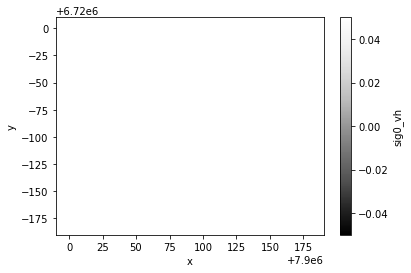

In [26]:
%matplotlib inline
sig0_vh_dc_chunk1.sig0_vh.min(dim='time').plot(cmap='Greys_r')

# Get Annual statstistics with xarray

In [ ]:
annual_vv = sig0_vv_dc_chunk1['sig0_vv'].groupby("time.year") 

In [ ]:
annual_vv.max('time')
#annual_vv.min('time')
#annual_vv.mean('count')
#annual_vv.median('time')
#annual_vv.std('time')
#annual_vv.quantile(0.9, 'time')
#annual_vv.quantile(0.1, 'time')

In [ ]:
MAD = annual_vv.map(lambda my_xr:  abs(my_xr - my_xr.median('time')).median('time'))

## xarray-approach: apply the time-seres analysis per each x, y location in xarray

Prepare timestamps

In [ ]:
ts_time_stamps = sig0_vv_dc_chunk1['sig0_vv'][:,0, 0].time.values

Get features per each pixel

In [ ]:
#%%timeit
dist_out = xr.apply_ufunc(features_as_xrrray_ufunc, 
                          sig0_vh_dc_chunk1['sig0_vh'],
                          ts_time_stamps,
                          input_core_dims=[["time"], []],
                          output_core_dims=[["features"]]
                         )

In [ ]:
#%%timeit
dist_out = xr.apply_ufunc(features_as_xrrray_ufunc, 
                          sig0_vv_dc_chunk1['sig0_vv'],
                          ts_time_stamps,
                          input_core_dims=[["time"], []],
                          output_core_dims=[["features"]]
                         )

In [ ]:
# convert output to dataset
dist_out_ds = dist_out.to_dataset(dim='features')

In [ ]:
dist_out_ds

In [ ]:
dist_out_ds = dist_out_ds.rename({0:'exception_label', 1:'ref_mean', 2:'error_margin',
                                  3:'num_of_segments', 4:'TS_end_flag', 5:'TS_end_flag_long', 6:'TS_end_mag',
                                  7:'seg_id', 8:'seg_size', 9:'max_mag', 10:'max_mag_date', 11:'t_pre', 12:'t_post', 13:'t_total',
                                  14:'max_mag_org', 15:'max_mag_org_date', 16:'t_mag_org',
                                  17:'seg2_size'})

In [ ]:
dist_out_ds

Global statistics (whole 4-year time seres considered)

In [ ]:
dist_out_ds['count_total'] = sig0_vv_dc_chunk1['sig0_vv'].count('time')
dist_out_ds['min_total'] = sig0_vv_dc_chunk1['sig0_vv'].min('time')
dist_out_ds['max_total'] = sig0_vv_dc_chunk1['sig0_vv'].max('time')
dist_out_ds['mean_total'] = sig0_vv_dc_chunk1['sig0_vv'].mean('time')
dist_out_ds['median_total'] = sig0_vv_dc_chunk1['sig0_vv'].median('time')
dist_out_ds['std_total'] = sig0_vv_dc_chunk1['sig0_vv'].std('time')
dist_out_ds['q10_total'] = sig0_vv_dc_chunk1['sig0_vv'].quantile(0.1, dim='time').drop('quantile', dim=None)
dist_out_ds['q90_total'] = sig0_vv_dc_chunk1['sig0_vv'].quantile(0.9, dim='time').drop('quantile', dim=None)
dist_out_ds['q25_total'] = sig0_vv_dc_chunk1['sig0_vv'].quantile(0.25, dim='time').drop('quantile', dim=None)
dist_out_ds['q75_total'] = sig0_vv_dc_chunk1['sig0_vv'].quantile(0.75, dim='time').drop('quantile', dim=None)

In [ ]:
# get the absolute deviation/residual (from median)
absMedRes_vv_da = xr.apply_ufunc(lambda ts:  abs(ts - np.nanmedian(ts)), 
                                 sig0_vv_dc_chunk1['sig0_vv'],
                                 input_core_dims=[["time"]],
                                 output_core_dims=[["time"]]
                                )

In [ ]:
# get MAD (median absolute deviation)
dist_out_ds['MAD_total'] = absMedRes_vv_da.median('time')

Annual statistics 

In [ ]:
dist_out_ds['count_2017'] = annual_vv.count('time').sel(year=2017, drop=True)
dist_out_ds['count_2018'] = annual_vv.count('time').sel(year=2018, drop=True)
dist_out_ds['count_2019'] = annual_vv.count('time').sel(year=2019, drop=True)
dist_out_ds['count_2020'] = annual_vv.count('time').sel(year=2020, drop=True)
#
dist_out_ds['max_2017'] = annual_vv.max('time').sel(year=2017, drop=True)
dist_out_ds['max_2018'] = annual_vv.max('time').sel(year=2018, drop=True)
dist_out_ds['max_2019'] = annual_vv.max('time').sel(year=2019, drop=True)
dist_out_ds['max_2020'] = annual_vv.max('time').sel(year=2020, drop=True)
#
dist_out_ds['min_2017'] = annual_vv.min('time').sel(year=2017, drop=True)
dist_out_ds['min_2018'] = annual_vv.min('time').sel(year=2018, drop=True)
dist_out_ds['min_2019'] = annual_vv.min('time').sel(year=2019, drop=True)
dist_out_ds['min_2020'] = annual_vv.min('time').sel(year=2020, drop=True)
#
dist_out_ds['mean_2017'] = annual_vv.mean('time').sel(year=2017, drop=True)
dist_out_ds['mean_2018'] = annual_vv.mean('time').sel(year=2018, drop=True)
dist_out_ds['mean_2019'] = annual_vv.mean('time').sel(year=2019, drop=True)
dist_out_ds['mean_2020'] = annual_vv.mean('time').sel(year=2020, drop=True)
#
dist_out_ds['median_2017'] = annual_vv.median('time').sel(year=2017, drop=True)
dist_out_ds['median_2018'] = annual_vv.median('time').sel(year=2018, drop=True)
dist_out_ds['median_2019'] = annual_vv.median('time').sel(year=2019, drop=True)
dist_out_ds['median_2020'] = annual_vv.median('time').sel(year=2020, drop=True)
#
dist_out_ds['std_2017'] = annual_vv.std('time').sel(year=2017, drop=True)
dist_out_ds['std_2018'] = annual_vv.std('time').sel(year=2018, drop=True)
dist_out_ds['std_2019'] = annual_vv.std('time').sel(year=2019, drop=True)
dist_out_ds['std_2020'] = annual_vv.std('time').sel(year=2020, drop=True)
#
dist_out_ds['q10_2017'] = annual_vv.quantile(0.1, 'time').sel(year=2017, drop=True).drop('quantile', dim=None)
dist_out_ds['q10_2018'] = annual_vv.quantile(0.1, 'time').sel(year=2018, drop=True).drop('quantile', dim=None)
dist_out_ds['q10_2019'] = annual_vv.quantile(0.1, 'time').sel(year=2019, drop=True).drop('quantile', dim=None)
dist_out_ds['q10_2020'] = annual_vv.quantile(0.1, 'time').sel(year=2020, drop=True).drop('quantile', dim=None)
#
dist_out_ds['q90_2017'] = annual_vv.quantile(0.9, 'time').sel(year=2017, drop=True).drop('quantile', dim=None)
dist_out_ds['q90_2018'] = annual_vv.quantile(0.9, 'time').sel(year=2018, drop=True).drop('quantile', dim=None)
dist_out_ds['q90_2019'] = annual_vv.quantile(0.9, 'time').sel(year=2019, drop=True).drop('quantile', dim=None)
dist_out_ds['q90_2020'] = annual_vv.quantile(0.9, 'time').sel(year=2020, drop=True).drop('quantile', dim=None)
#
dist_out_ds['q25_2017'] = annual_vv.quantile(0.25, 'time').sel(year=2017, drop=True).drop('quantile', dim=None)
dist_out_ds['q25_2018'] = annual_vv.quantile(0.25, 'time').sel(year=2018, drop=True).drop('quantile', dim=None)
dist_out_ds['q25_2019'] = annual_vv.quantile(0.25, 'time').sel(year=2019, drop=True).drop('quantile', dim=None)
dist_out_ds['q25_2020'] = annual_vv.quantile(0.25, 'time').sel(year=2020, drop=True).drop('quantile', dim=None)
#
dist_out_ds['q75_2017'] = annual_vv.quantile(0.75, 'time').sel(year=2017, drop=True).drop('quantile', dim=None)
dist_out_ds['q75_2018'] = annual_vv.quantile(0.75, 'time').sel(year=2018, drop=True).drop('quantile', dim=None)
dist_out_ds['q75_2019'] = annual_vv.quantile(0.75, 'time').sel(year=2019, drop=True).drop('quantile', dim=None)
dist_out_ds['q75_2020'] = annual_vv.quantile(0.75, 'time').sel(year=2020, drop=True).drop('quantile', dim=None)
#
MAD = annual_vv.map(lambda my_xr:  abs(my_xr - my_xr.median('time')).median('time'))
#
dist_out_ds['MAD_2017'] = MAD.sel(year=2017, drop=True)
dist_out_ds['MAD_2018'] = MAD.sel(year=2018, drop=True)
dist_out_ds['MAD_2019'] = MAD.sel(year=2019, drop=True)
dist_out_ds['MAD_2020'] = MAD.sel(year=2020, drop=True)

In [ ]:
dist_out_ds

# Some plotting just for fun

In [ ]:
dist_out_ds.std_total.plot()

In [ ]:
dist_out_ds.MAD_total.plot()

In [ ]:
(dist_out_ds.q75_total - dist_out_ds.q25_total).plot()

In [ ]:
(dist_out_ds.q90_total - dist_out_ds.q10_total).plot()

In [ ]:
(dist_out_ds.max_total - dist_out_ds.min_total).plot()